In [45]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_history(history):
    plt.figure(figsize=(15, 5))

    # Subplot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')

    # Subplot for loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()


def cm_plot(conf_matrix, labels, drug):
    plt.figure(figsize=(8, 5))
    sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {drug}')
    plt.show()

Load data

In [46]:
import tensorflow as tf
import pandas as pd

# Load the dataset
cols = ['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'N-Score', 'E-Score', 'O-Score', 'A-Score', 'C-Score', 'Impulsive', 'ImpSS', 'Alcohol', 'Amphetamine',
        'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']

df = pd.read_csv('./data/drug_consumption.data', names=cols)

df.pop('ID')
df.pop('Alcohol')
df.pop('Amyl')
df.pop('Caff')
df.pop('Choc')
df.pop('Crack')
df.pop('Heroin')
df.pop('Semer')
df.pop('VSA')

cols = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'N-Score', 'E-Score',
        'O-Score', 'A-Score', 'C-Score', 'Impulsive', 'ImpSS'] + list(df.columns[13:])

Data Preprocessing

In [47]:
def convert_to_binary(cl_value):
    return 0 if cl_value in ['CL0', 'CL1', 'CL2'] else 1


for col in df.columns[12:]:
    df[col] = df[col].apply(convert_to_binary)

x = df.iloc[:, :12]
y = df.iloc[:, 12:]
drugs = y.columns

Model


Training for Amphetamine...
Epoch 1/200
71/71 [==============================] - 2s 11ms/step - loss: 0.5089 - accuracy: 0.7442 - val_loss: 0.3962 - val_accuracy: 0.8127
Epoch 2/200
71/71 [==============================] - 1s 8ms/step - loss: 0.4452 - accuracy: 0.7681 - val_loss: 0.3942 - val_accuracy: 0.8127
Epoch 3/200
71/71 [==============================] - 1s 8ms/step - loss: 0.4482 - accuracy: 0.7858 - val_loss: 0.4100 - val_accuracy: 0.8233
Epoch 4/200
71/71 [==============================] - 1s 8ms/step - loss: 0.4392 - accuracy: 0.7690 - val_loss: 0.3914 - val_accuracy: 0.8304
Epoch 5/200
71/71 [==============================] - 1s 8ms/step - loss: 0.4257 - accuracy: 0.7903 - val_loss: 0.3979 - val_accuracy: 0.8233
Epoch 6/200
71/71 [==============================] - 1s 8ms/step - loss: 0.4171 - accuracy: 0.7894 - val_loss: 0.4008 - val_accuracy: 0.8092
Epoch 7/200
71/71 [==============================] - 1s 8ms/step - loss: 0.4212 - accuracy: 0.7867 - val_loss: 0.3971 - val_a

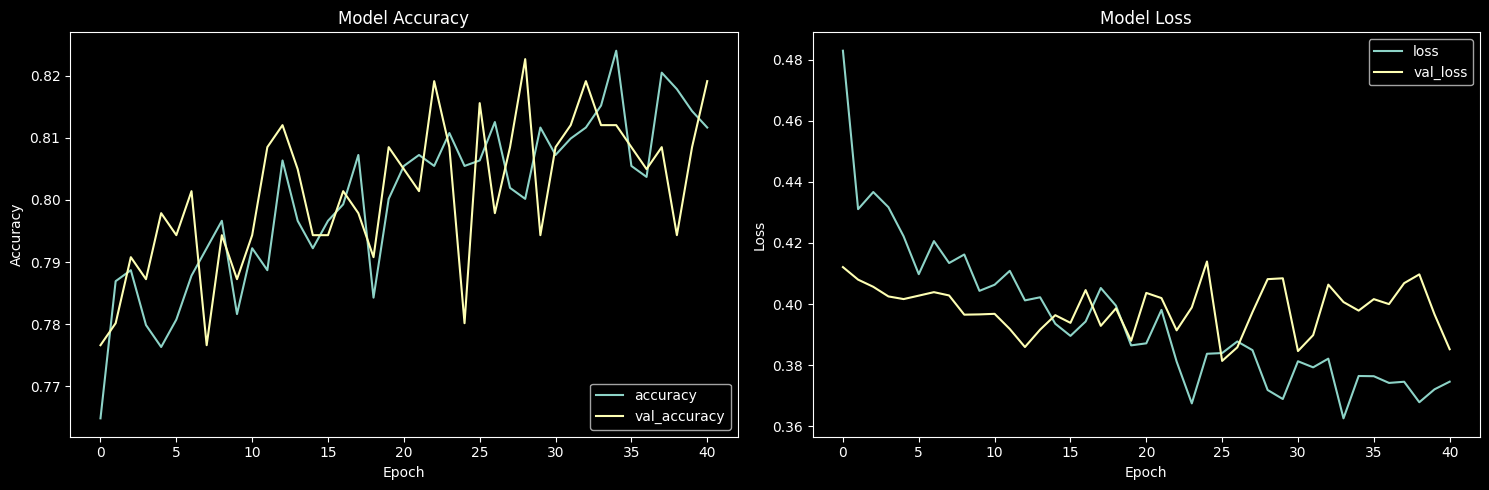

              precision    recall  f1-score   support

    Non-User       0.84      0.87      0.85       366
        User       0.49      0.44      0.47       106

    accuracy                           0.77       472
   macro avg       0.67      0.65      0.66       472
weighted avg       0.76      0.77      0.77       472



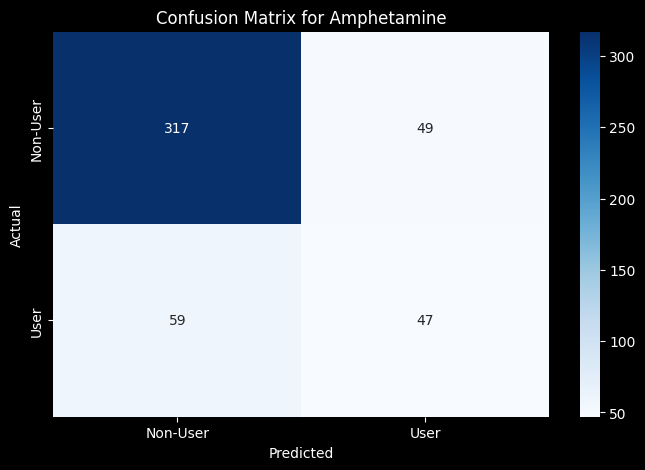

15/15 [==============================] - 0s 3ms/step
Evaluation for Benzos on the test set:


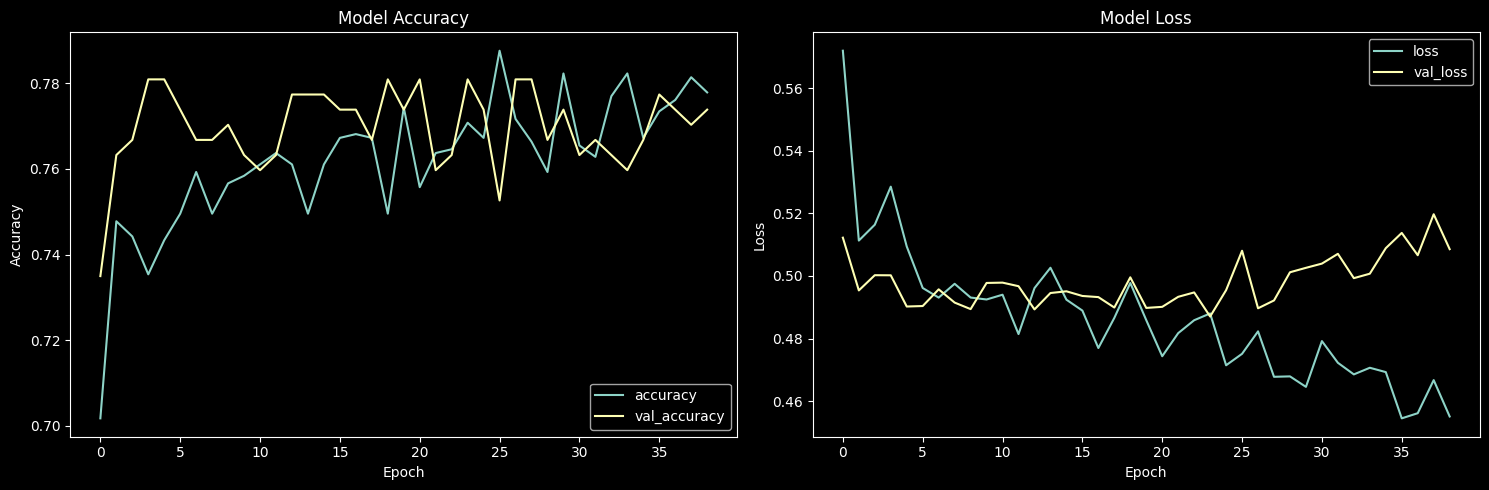

              precision    recall  f1-score   support

    Non-User       0.77      0.87      0.82       330
        User       0.56      0.38      0.45       142

    accuracy                           0.72       472
   macro avg       0.66      0.63      0.63       472
weighted avg       0.70      0.72      0.71       472



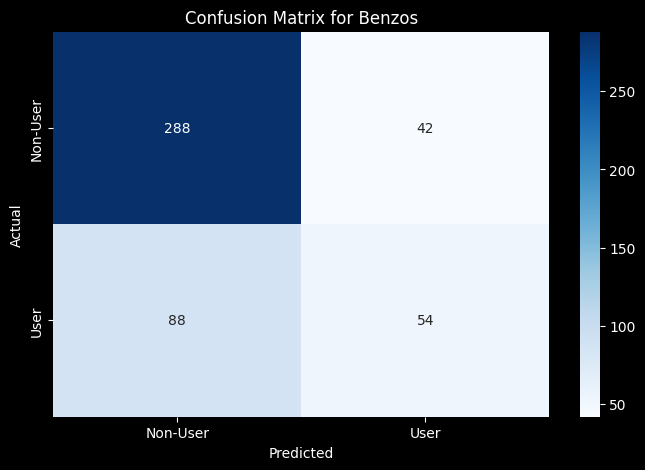

15/15 [==============================] - 0s 2ms/step
Evaluation for Cannabis on the test set:


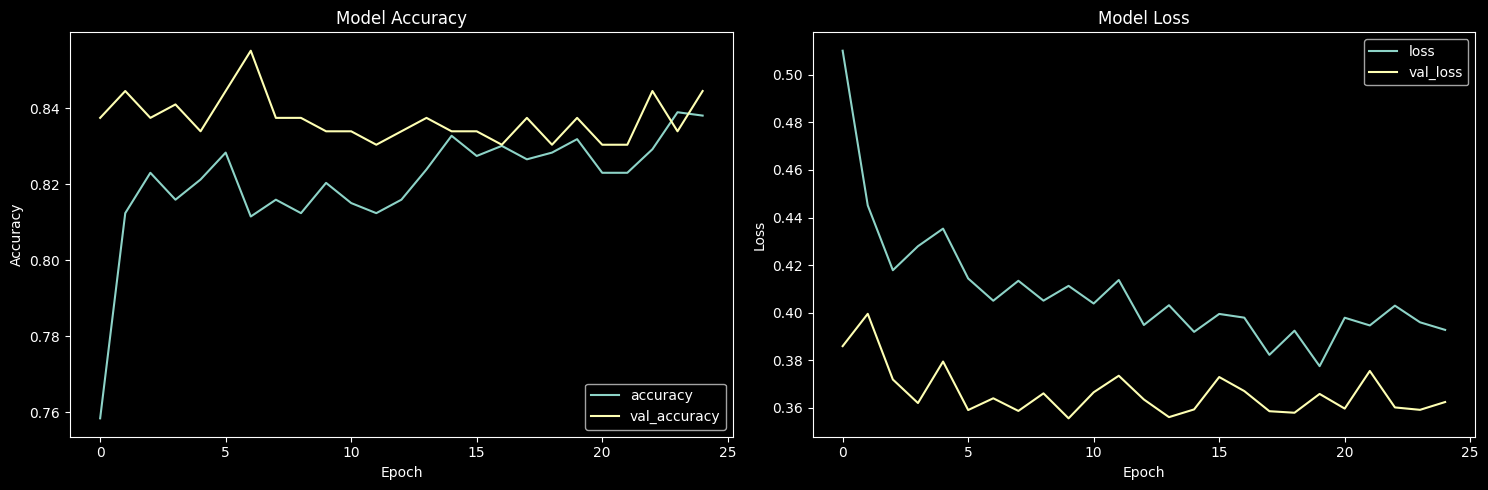

              precision    recall  f1-score   support

    Non-User       0.75      0.77      0.76       205
        User       0.82      0.80      0.81       267

    accuracy                           0.79       472
   macro avg       0.78      0.79      0.79       472
weighted avg       0.79      0.79      0.79       472



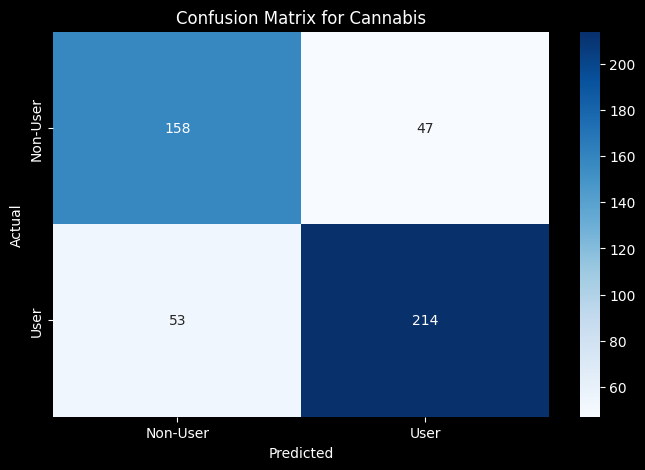

15/15 [==============================] - 0s 3ms/step
Evaluation for Coke on the test set:


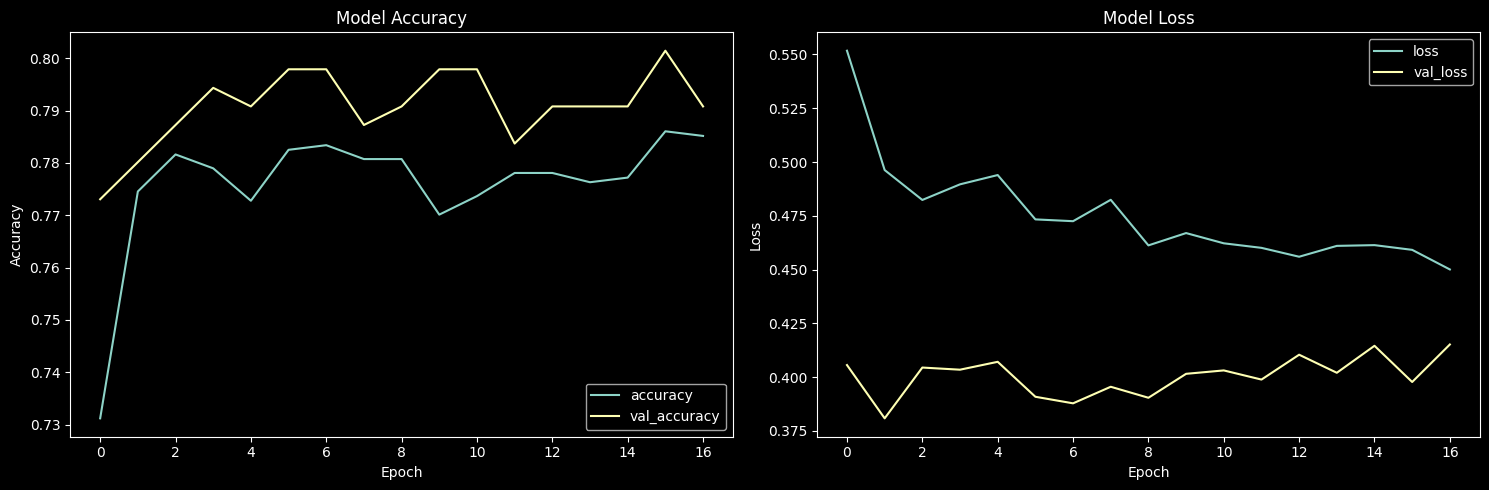

              precision    recall  f1-score   support

    Non-User       0.80      0.98      0.88       366
        User       0.67      0.17      0.27       106

    accuracy                           0.79       472
   macro avg       0.73      0.57      0.58       472
weighted avg       0.77      0.79      0.74       472



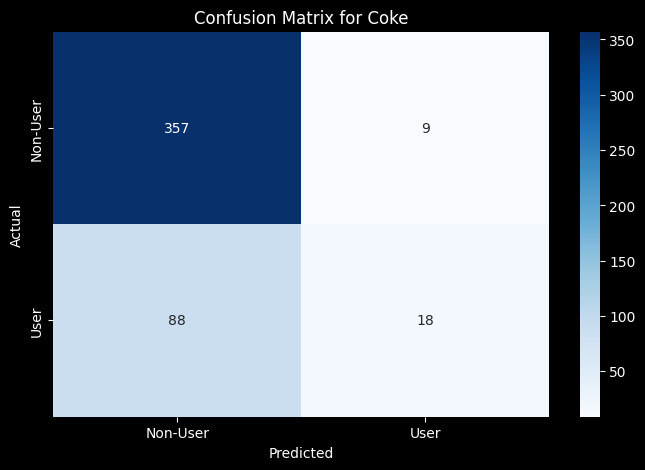

15/15 [==============================] - 0s 2ms/step
Evaluation for Ecstasy on the test set:


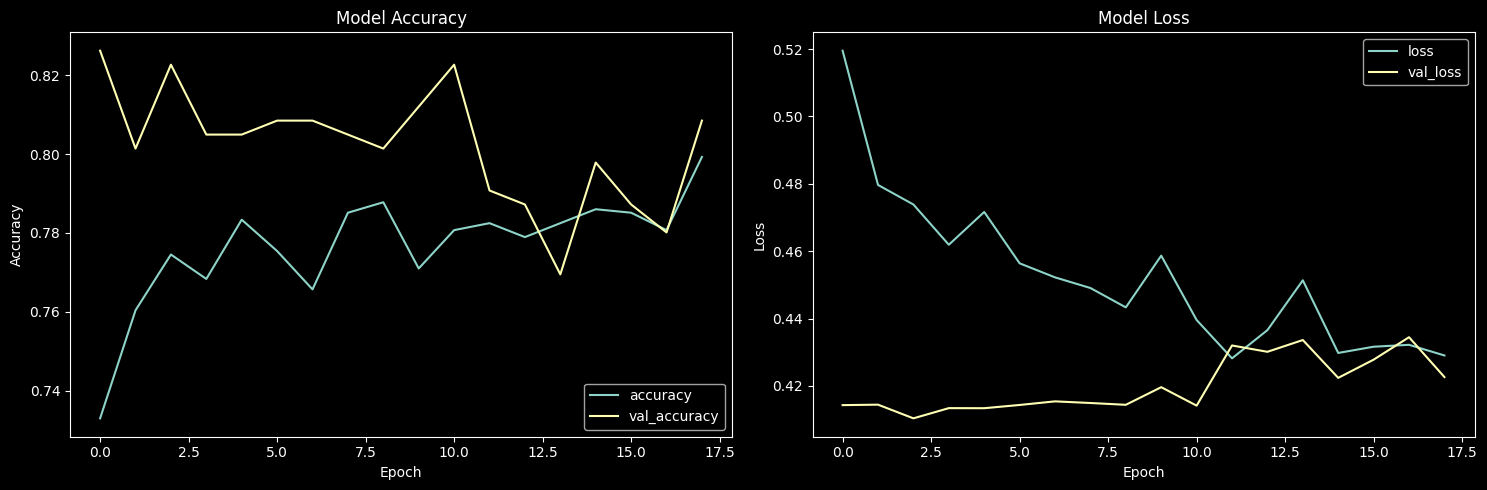

              precision    recall  f1-score   support

    Non-User       0.83      0.82      0.82       339
        User       0.55      0.56      0.56       133

    accuracy                           0.75       472
   macro avg       0.69      0.69      0.69       472
weighted avg       0.75      0.75      0.75       472



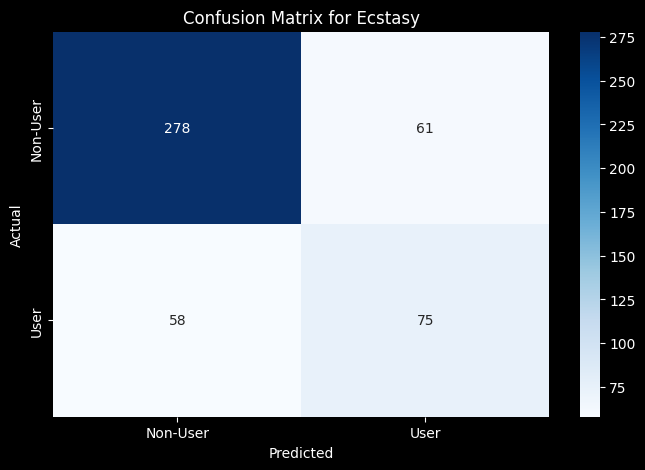

15/15 [==============================] - 0s 3ms/step
Evaluation for Ketamine on the test set:


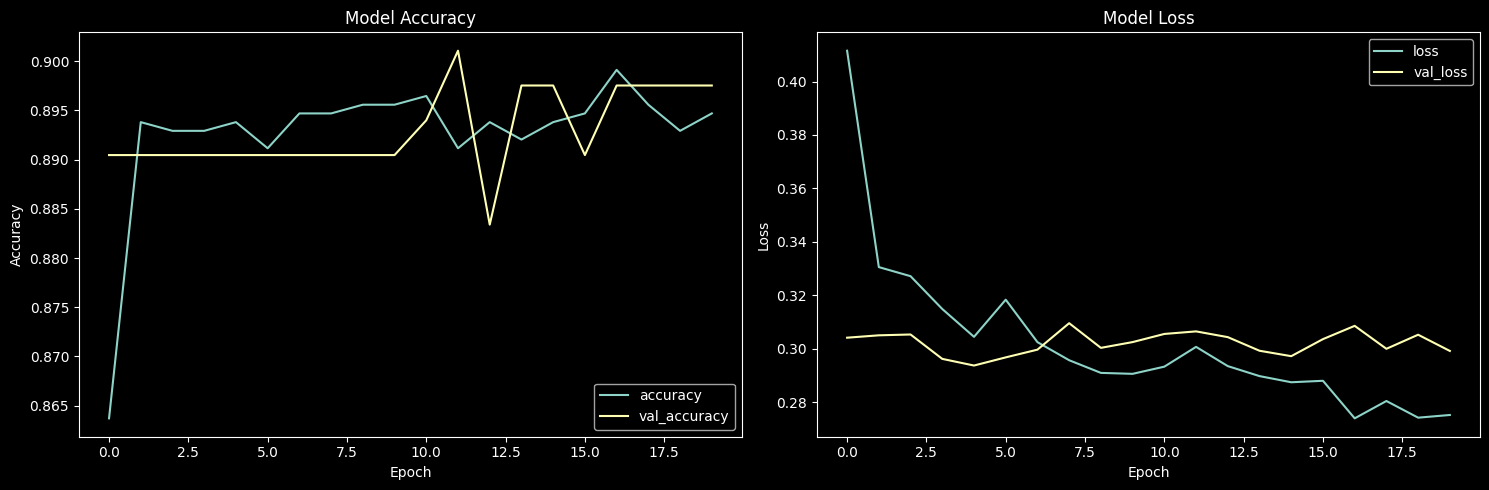

              precision    recall  f1-score   support

    Non-User       0.89      1.00      0.94       415
        User       0.80      0.07      0.13        57

    accuracy                           0.89       472
   macro avg       0.84      0.53      0.53       472
weighted avg       0.88      0.89      0.84       472



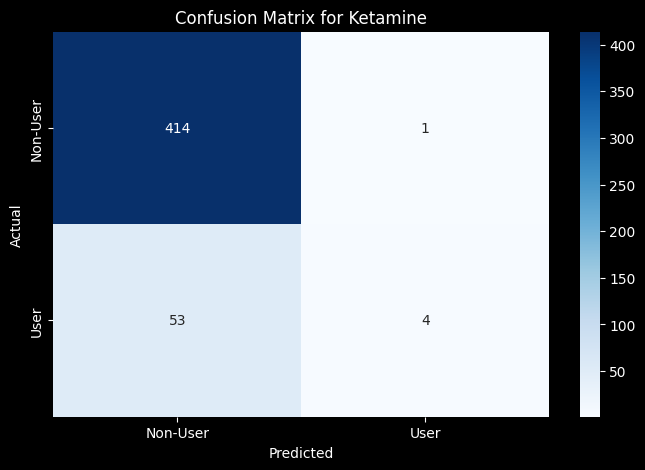

15/15 [==============================] - 0s 3ms/step
Evaluation for Legalh on the test set:


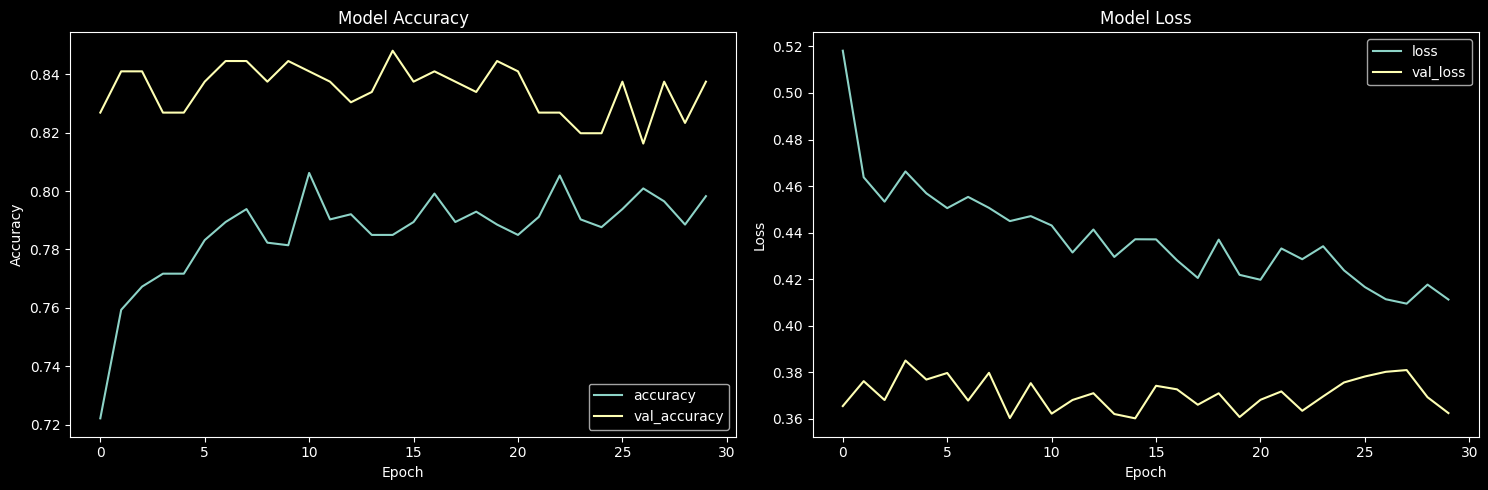

              precision    recall  f1-score   support

    Non-User       0.80      0.86      0.83       319
        User       0.65      0.56      0.60       153

    accuracy                           0.76       472
   macro avg       0.73      0.71      0.71       472
weighted avg       0.75      0.76      0.76       472



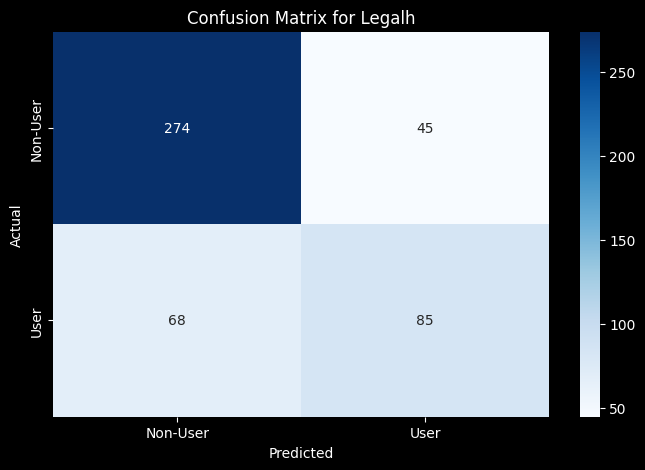

15/15 [==============================] - 0s 3ms/step
Evaluation for LSD on the test set:


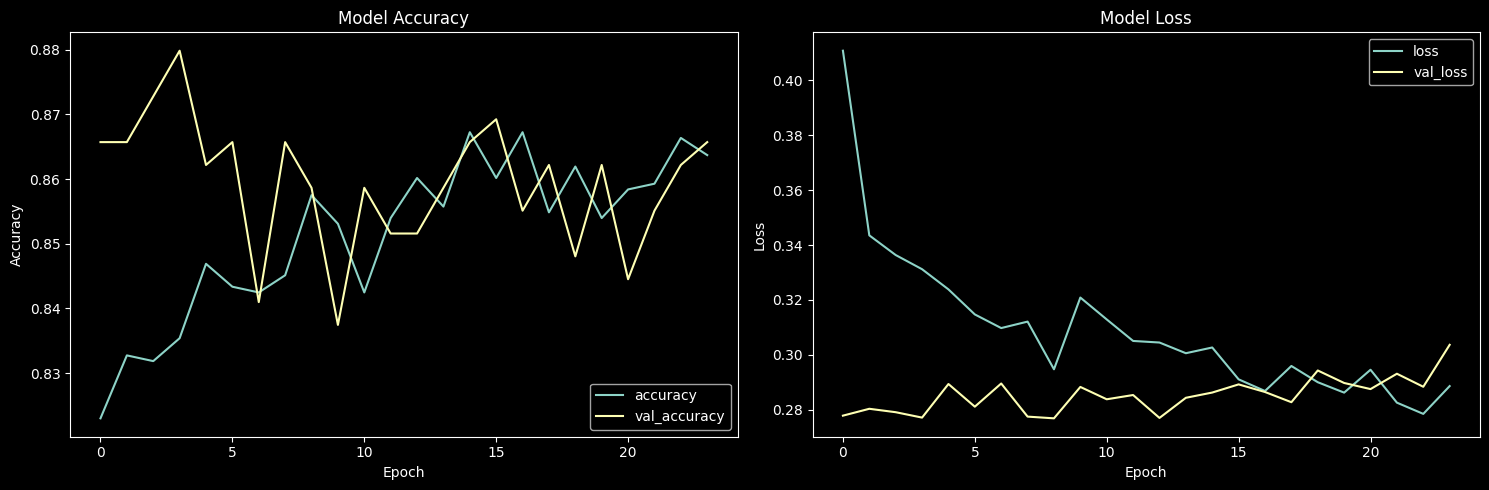

              precision    recall  f1-score   support

    Non-User       0.89      0.83      0.86       373
        User       0.49      0.60      0.54        99

    accuracy                           0.78       472
   macro avg       0.69      0.71      0.70       472
weighted avg       0.80      0.78      0.79       472



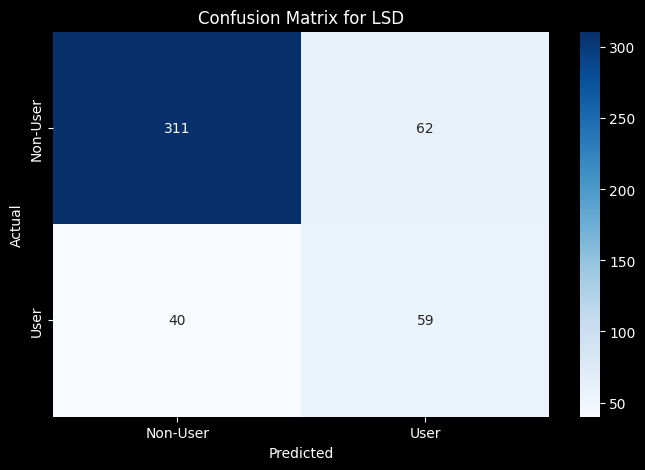

15/15 [==============================] - 0s 3ms/step
Evaluation for Meth on the test set:


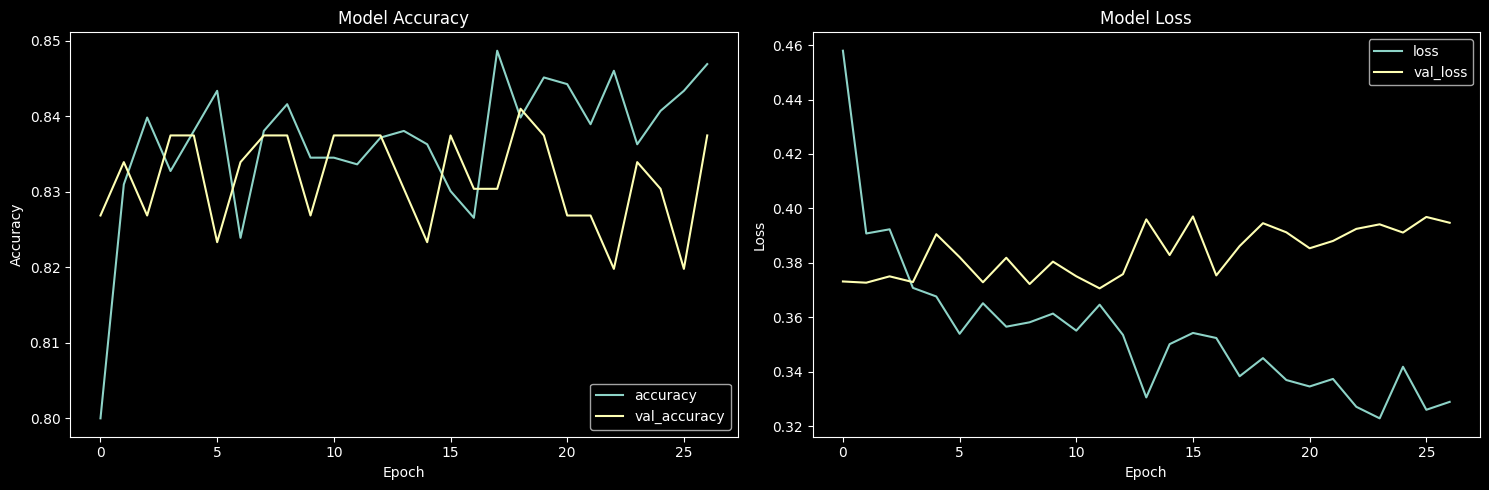

              precision    recall  f1-score   support

    Non-User       0.82      0.98      0.89       384
        User       0.46      0.07      0.12        88

    accuracy                           0.81       472
   macro avg       0.64      0.52      0.51       472
weighted avg       0.75      0.81      0.75       472



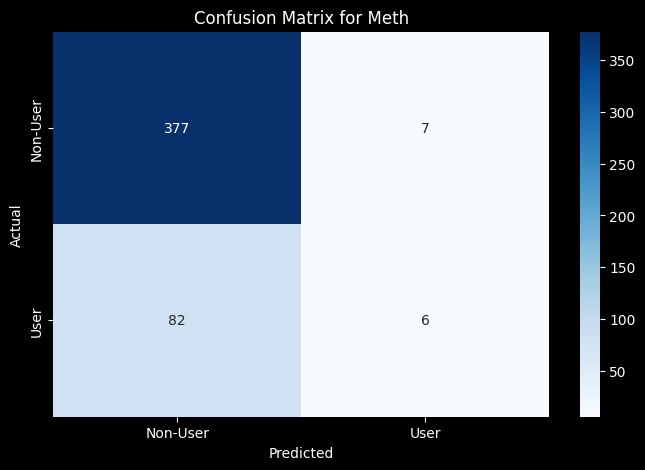

15/15 [==============================] - 0s 4ms/step
Evaluation for Mushrooms on the test set:


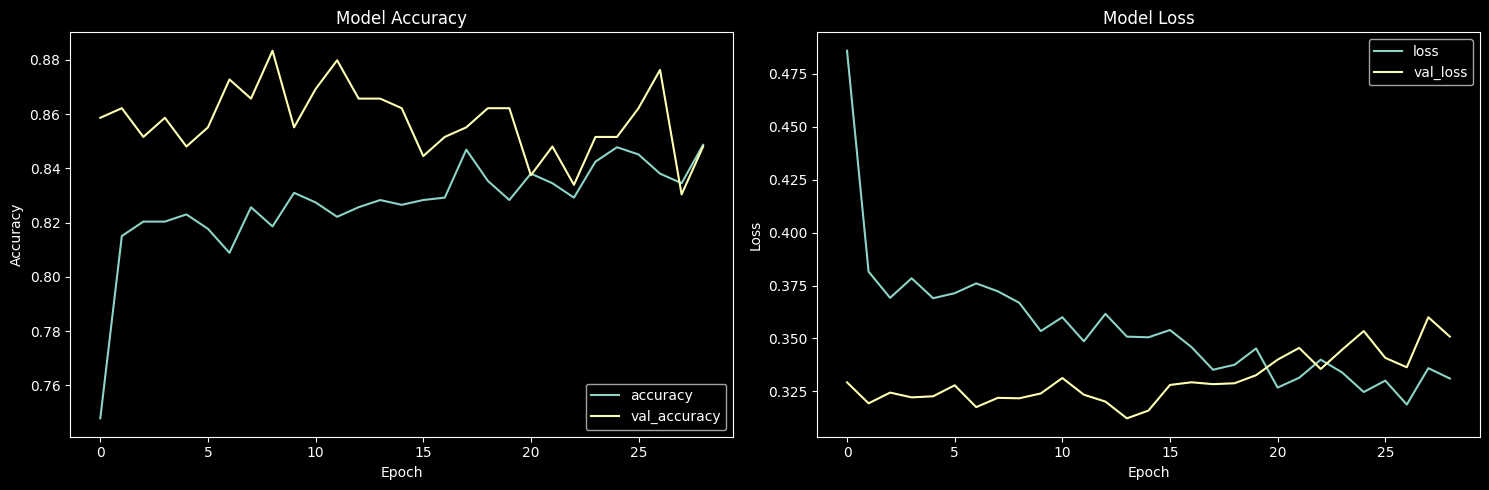

              precision    recall  f1-score   support

    Non-User       0.87      0.86      0.87       358
        User       0.58      0.60      0.59       114

    accuracy                           0.80       472
   macro avg       0.72      0.73      0.73       472
weighted avg       0.80      0.80      0.80       472



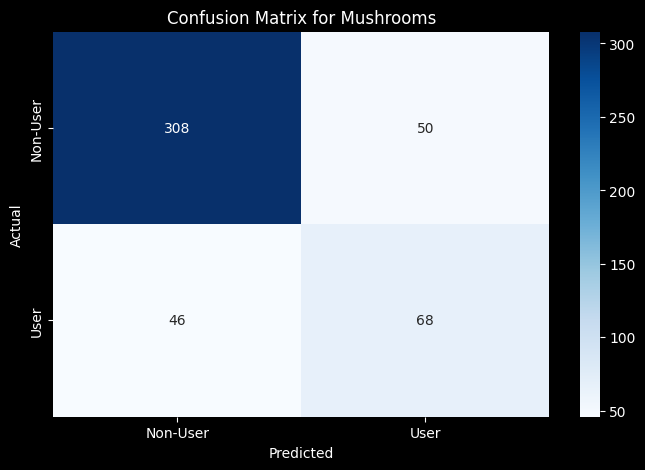

15/15 [==============================] - 0s 4ms/step
Evaluation for Nicotine on the test set:


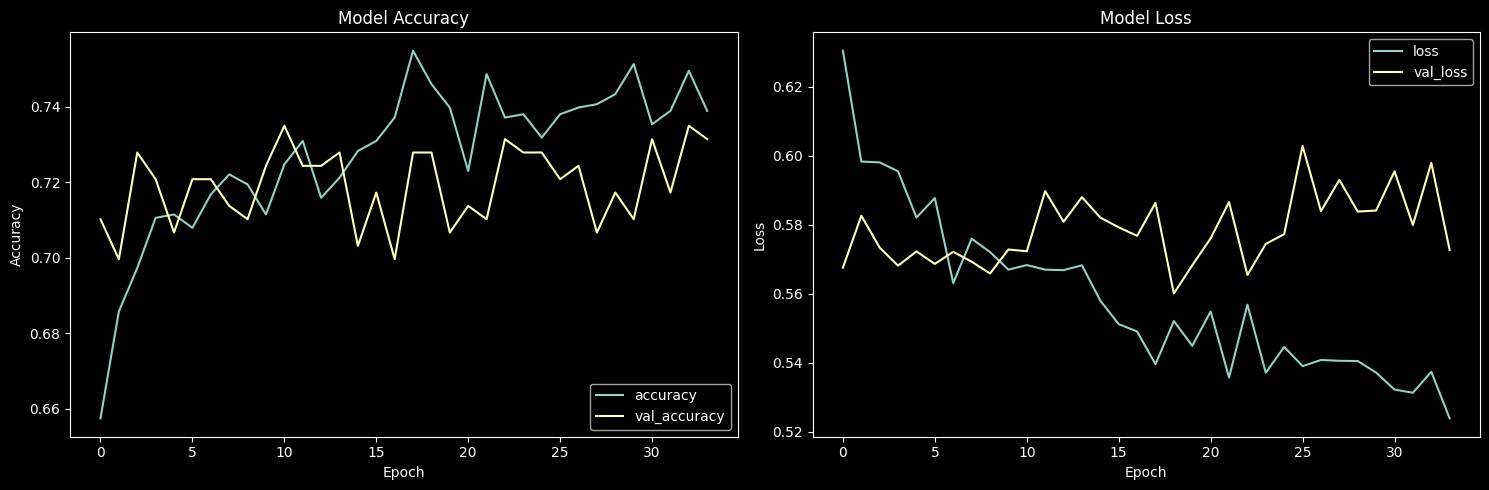

              precision    recall  f1-score   support

    Non-User       0.68      0.65      0.66       206
        User       0.73      0.76      0.75       266

    accuracy                           0.71       472
   macro avg       0.70      0.70      0.70       472
weighted avg       0.71      0.71      0.71       472



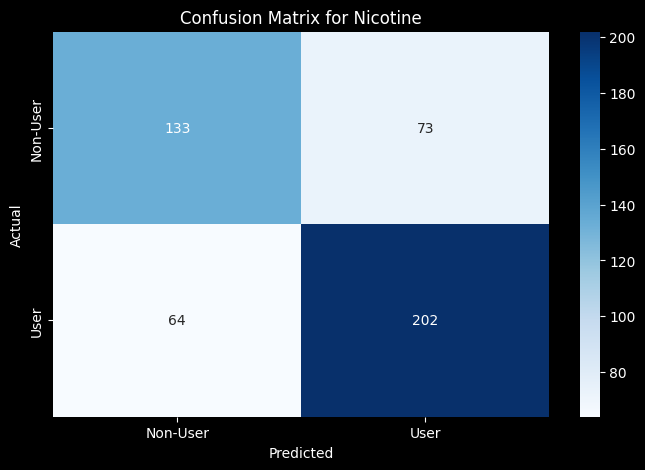

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

epochs = 200
batch_size = 16
dropout = 0.3

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# best accuracies and models
best_accuracies = {drug: 0 for drug in drugs}
best_histories = {drug: None for drug in drugs}
best_models = {drug: None for drug in drugs}

for drug in drugs:
    print(f"Training for {drug}...")
    y_train_full_drug = y_train_full[drug]

    for index, (train_indices, val_indices) in enumerate(skf.split(x_train_full, y_train_full_drug)):
        # Split data into folds
        x_train_fold, x_val_fold = x_train_full.iloc[train_indices], x_train_full.iloc[val_indices]
        y_train_fold, y_val_fold = y_train_full_drug.iloc[
            train_indices], y_train_full_drug.iloc[val_indices]

        x_train_fold_scaled = scaler.fit_transform(x_train_fold)
        x_val_fold_scaled = scaler.transform(x_val_fold)

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, input_shape=(
                x_train_fold_scaled.shape[1],)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(dropout),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(dropout),

            tf.keras.layers.Dense(64),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(dropout),

            tf.keras.layers.Dense(32),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(dropout),

            tf.keras.layers.Dense(16),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(dropout),

            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam',
                      loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(x_train_fold_scaled, y_train_fold, epochs=epochs, batch_size=batch_size, validation_data=(
            x_val_fold_scaled, y_val_fold), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1)], verbose=1)

        # Evaluate the model on the validation set
        _, accuracy = model.evaluate(x_val_fold_scaled, y_val_fold, verbose=1)

        # Update best accuracy and model if current model is better
        if accuracy > best_accuracies[drug]:
            best_accuracies[drug] = accuracy
            best_models[drug] = model
            best_histories[drug] = history.history

            # Predict on validation fold
            y_pred_fold = (model.predict(x_val_fold_scaled) > 0.5).astype(int)

# Final evaluation on test set
scaler.fit(x_train_full)
x_test_scaled = scaler.transform(x_test)

# Evaluate the best models on the test set
for drug in drugs:
    model = best_models[drug]
    history = best_histories[drug]

    if model is not None:
        y_pred_test = (model.predict(x_test_scaled) > 0.5).astype(int)

        # Generate classification report and confusion matrix for the test set
        classification_report_test = classification_report(
            y_test[drug], y_pred_test, target_names=['Non-User', 'User'], zero_division=1)
        confusion_matrix_test = confusion_matrix(y_test[drug], y_pred_test)

        # Output the performance
        print(f"Evaluation for {drug} on the test set:")
        plot_history(history)
        print(classification_report_test)
        cm_plot(confusion_matrix_test, ['Non-User', 'User'], drug)